In [1]:
from all_functions import *
from clustering_functions import *

In [3]:
nodenames = np.array(importdata("SP100_20170612.csv")[0].columns)

In [4]:
trees = MST(filename="SP100_20170612.csv", window=100, 
            enddate=importdata("SP100_20170612.csv")[0].index[-1].strftime('%Y-%m-%d'),
            startdate=importdata("SP100_20170612.csv")[0].index[-101].strftime('%Y-%m-%d'),
            space=1)

In [5]:
sorteddates = sorted(trees.keys(), key=lambda d: map(int, d.split('-')))

In [6]:
IGtrees = {}
for key in sorteddates:
    IGtrees[key] = NXtoIG(trees[key])

<p>Newman - community_leading_eigenvector()</p>
<p>Newman Girvan - nx.girvan_newman()</p>
<p>Newman Clauset - community_fastgreedy()</p>

In [7]:
clustersGirvanNewman2 = {}
clustersGirvanNewman4 = {}
clustersGirvanNewman8 = {}
clustersGirvanNewman16 = {}
for key in sorteddates:
    C = tuple(nx.girvan_newman(trees[key]))
    clustersGirvanNewman2[key] = C[0]
    clustersGirvanNewman4[key] = C[2]
    clustersGirvanNewman8[key] = C[6]
    clustersGirvanNewman16[key] = C[14]

In [7]:
ig.arpack_options.maxiter=500000
clustersNewman = {}
clustersClausetNewman = {}
for key in sorteddates:
    C = IGtrees[key].community_leading_eigenvector(weights="weight")
    clustersNewman[key] = list(C)
    for i in range(0,len(C)):
        clustersNewman[key][i] = [IGtrees[key].vs["name"][j] for j in C[i]]
    C = IGtrees[key].community_fastgreedy(weights="weight").as_clustering()
    clustersClausetNewman[key] = list(C)
    for i in range(0,len(C)):
        clustersClausetNewman[key][i] = [IGtrees[key].vs["name"][j] for j in C[i]]

In [9]:
ARI = pd.DataFrame(index=sorteddates[1:])
ARI['GN-2'] = movingARI(clustersGirvanNewman2,nodenames)
ARI['GN-4'] = movingARI(clustersGirvanNewman4,nodenames)
ARI['GN-8'] = movingARI(clustersGirvanNewman8,nodenames)
ARI['GN-16'] = movingARI(clustersGirvanNewman16,nodenames)
ARI['Newman'] = movingARI(clustersNewman,nodenames)
ARI['ClausetNewman'] = movingARI(clustersClausetNewman,nodenames)
%matplotlib inline
ARI.loc[:, ['GN-8',"Newman","ClausetNewman"]].plot(figsize=(20,8))

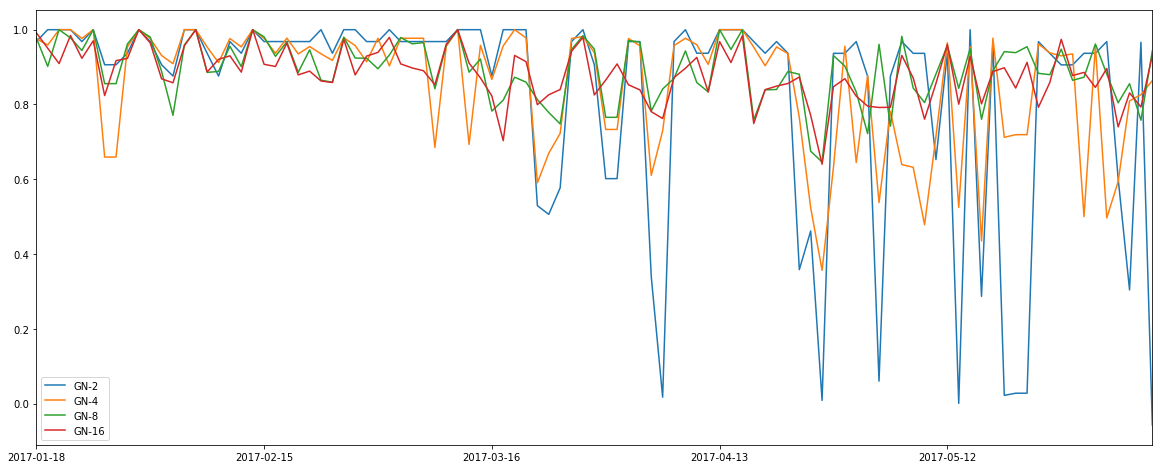

In [25]:
ARI.loc[:, ['GN-2','GN-4','GN-8','GN-16']].plot(figsize=(20,8))

                   mean
GN-2           0.826727
GN-4           0.855733
GN-8           0.893162
GN-16          0.881701
Newman         0.813611
ClausetNewman  0.876155


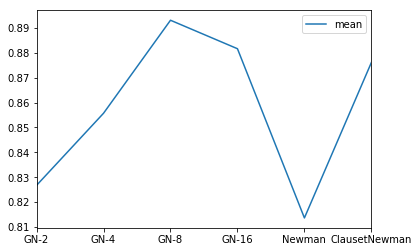

In [10]:
ARImean = pd.DataFrame(index=ARI.columns)
ARImean['mean'] = [np.mean(ARI[i]) for i in ARI.columns]
print(ARImean)
ARImean.plot()

Newman           14.08
ClausetNewman    11.80
dtype: float64


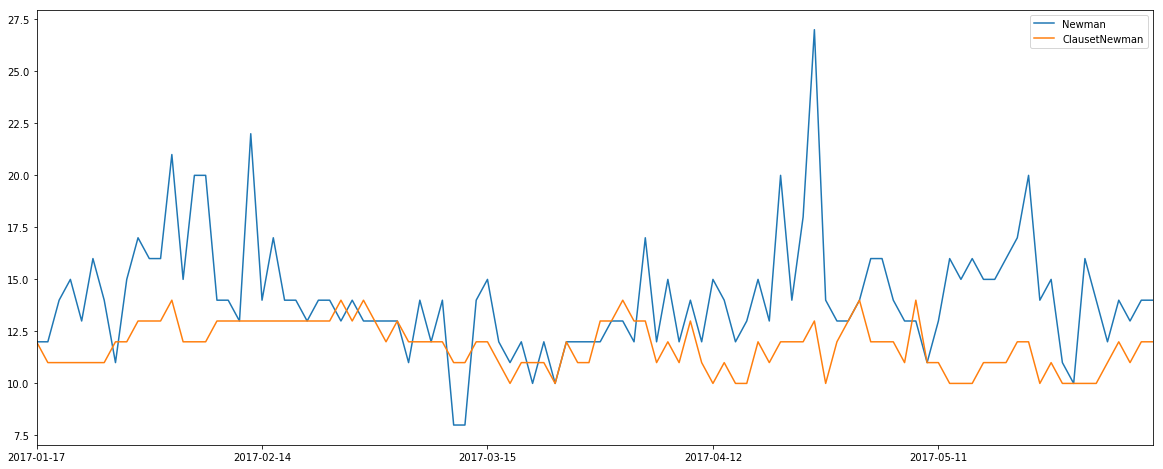

In [11]:
nofclusters = pd.DataFrame(index=sorteddates)
nofclusters['Newman'] = [len(clustersNewman[sorteddates[i]]) for i in range(0,len(sorteddates))]
nofclusters['ClausetNewman']=[len(clustersClausetNewman[sorteddates[i]]) for i in range(0,len(sorteddates))]
print(np.mean(nofclusters))
nofclusters.plot(figsize = (20,8))

In [ ]:
df = importdata("SP100_prices.csv")[1]
enddate = "2017-01-24"
startdate = '2015-12-30'   
end = int(np.where(df.index==enddate)[0])
start = int(np.where(df.index==startdate)[0])
total_trees = MST(filename="SP100_prices.csv", window=end-start+1, enddate="2017-01-24", startdate='2015-12-30'
                  ,space=1)
C = NXtoIG(total_trees[sorteddates[0]]).community_fastgreedy(weights="weight").as_clustering()
total_clusters = list(C)
for i in range(0,len(C)):
    total_clusters[i] = [NXtoIG(total_trees[sorteddates[0]]).vs["name"][j] for j in C[i]]

In [ ]:
HGT = HGT_clustering(total_clusters,clustersClausetNewman,nodenames)
HGT

In [30]:
NewmanUniverse = {}
ClausetNewmanUniverse = {}
for measure in ['degree','closeness','betweenness']:
    NewmanUniverse[measure] = clustering_universe(trees,clustersNewman,measure,quantile=0)
    ClausetNewmanUniverse[measure] = clustering_universe(trees,clustersClausetNewman,measure,quantile=0)
    
universes = {}
universes['Newman'] = NewmanUniverse
universes['ClausetNewman'] = ClausetNewmanUniverse

In [39]:
text_file = open("Central-NewmanBetweenness.txt", "w")
for t in sorteddates:
    text_file.write('%s: '% t)
    for stock in universes['Newman']['betweenness'][t]['central']:
        text_file.write('%s '% stock)
    text_file.write('\n')
text_file.close()

In [ ]:
download_daily_data(nodenames,'SP10006122017.h5')

In [75]:
store = pd.HDFStore('SP10006122017.h5')
df = store[nodenames[0]]
df = df.drop(df.columns[[0,1,2,3,5]], axis=1)
df.columns = [nodenames[0]]
for i in range(1,len(nodenames)):
    temp = store[nodenames[i]]
    temp = temp.drop(temp.columns[[0,1,2,3,5]], axis=1)
    temp.columns = [nodenames[i]]
    df = pd.concat([df, temp], axis=1)
df.sort_index(ascending = False).to_csv('SP100_20170612.csv')

In [ ]:
price, log_ret = importdata("SP100_prices.csv")
ret = price/price.shift(1)
ret = ret.iloc[1:]
space = 10
univdates = sorted(universes['Newman']['degree'].keys(), key=lambda d: map(int, d.split('-')))
pricedates = sorted(pd.read_csv("SP100_prices.csv")["Date"], key=lambda d: map(int, d.split('-')))
SP100Performance_weighted = {}
SP100Performance_weighted[univdates[0]]=1
SP100Performance_unweighted = {}
SP100Performance_unweighted[univdates[0]]=1
for t in univdates:
    cov = cov_matrix(ret, price.keys(),250,t)
    weights = np.transpose(min_variance_weights(cov)[0])[0]
    for tt in pricedates[pricedates.index(t)+1:
                            pricedates.index(t)+1+space]:
        SP100Performance_weighted[tt] = SP100Performance_weighted[t]*np.dot(weights,np.divide(price[tt:tt].as_matrix()[0],
                                                            price[t:t].as_matrix()[0]))
    weights = np.divide(np.ones(len(cov)),len(cov))
    for tt in pricedates[pricedates.index(t)+1:
                            pricedates.index(t)+1+space]:
        SP100Performance_unweighted[tt] = SP100Performance_unweighted[t]*np.dot(weights,np.divide(price[tt:tt].as_matrix()[0],
                                                            price[t:t].as_matrix()[0]))
df = pd.DataFrame([[key,value] for key,value in SP100Performance_weighted.iteritems()],columns=["Date","SP100"])
df = df.set_index(pd.DatetimeIndex(df['Date']))
df = df.drop(['Date'], axis=1)
df.sort_index(inplace=True)
performance_comparison_weighted['benchmark'] = df
df = pd.DataFrame([[key,value] for key,value in SP100Performance_unweighted.iteritems()],columns=["Date","SP100"])
df = df.set_index(pd.DatetimeIndex(df['Date']))
df = df.drop(['Date'], axis=1)
df.sort_index(inplace=True)
performance_comparison_unweighted['benchmark'] = df

In [ ]:
performance_comparison_unweighted = {}
for method in ['Newman','ClausetNewman']:
    performance_comparison_unweighted[method] = {}
    for measure in ['degree','closeness','betweenness']:
        temp = clustering_performance(universes[method][measure],weighted = 'FALSE')
        temp['SP100'] = SP100Performance_unweighted
        performance_comparison_unweighted[method][measure] = pd.DataFrame.from_dict(temp)
performance_comparison_weighted = {}
for method in ['Newman','ClausetNewman']:
    performance_comparison_weighted[method] = {}
    for measure in ['degree','closeness','betweenness']:
        temp = clustering_performance(universes[method][measure],weighted = 'TRUE')
        temp['SP100'] = SP100Performance_weighted
        performance_comparison_weighted[method][measure] = pd.DataFrame.from_dict(temp)

In [ ]:
performance_comparison_weighted['ClausetNewman']['betweenness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_weighted['Newman']['betweenness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_weighted['ClausetNewman']['closeness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_weighted['Newman']['closeness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_weighted['Newman']['degree'].plot(figsize=(20,8))

In [ ]:
performance_comparison_weighted['ClausetNewman']['degree'].plot(figsize=(20,8))

In [ ]:
performance_comparison_unweighted['ClausetNewman']['betweenness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_unweighted['Newman']['betweenness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_unweighted['ClausetNewman']['degree'].plot(figsize=(20,8))

In [ ]:
performance_comparison_unweighted['Newman']['degree'].plot(figsize=(20,8))

In [ ]:
performance_comparison_unweighted['ClausetNewman']['closeness'].plot(figsize=(20,8))

In [ ]:
performance_comparison_unweighted['Newman']['closeness'].plot(figsize=(20,8))

In [ ]:
for method in ['Newman','ClausetNewman']:
    for measure in ['degree','closeness','betweenness']:
        print(method)
        print(measure)
        print(np.sqrt(np.var(performance_comparison_weighted[method][measure]/
                     performance_comparison_weighted[method][measure].shift(1))))

In [17]:
x = [[1],[1,2,3],[1,2,3,4],[1,2]]
x = {i+1:x[i] for i in range(len(x))}

In [19]:
max(keys)

4

In [18]:
keys = sorted(x, key=lambda k: len(x[k]), reverse=True)

In [11]:
ordered_keys = sorted(results[sorteddates[0]], key=lambda k: len(results[sorteddates[0]][k]), reverse=True)

In [12]:
clustersClausetNewman[sorteddates[0]]

[['AXP', 'BK', 'USB', 'WBA', 'CVS', 'TWX'],
 ['NSC',
  'GE',
  'GM',
  'XLI',
  'EMR',
  'UPS',
  'UNP',
  'F',
  'WMT',
  'EBAY',
  'MMM',
  'XHB',
  'CAT',
  'FDX',
  'HON',
  'UTX'],
 ['BA', 'XAR', 'GD', 'RTN', 'LMT'],
 ['AAPL',
  'AMZN',
  'ACN',
  'T',
  'XLK',
  'INTC',
  'VZ',
  'MA',
  'FB',
  'MSFT',
  'IBM',
  'V',
  'GOOG'],
 ['XBI',
  'XPH',
  'MRK',
  'XLV',
  'LLY',
  'BMY',
  'JNJ',
  'ABBV',
  'AMGN',
  'GILD',
  'BIIB',
  'PFE'],
 ['EXC',
  'SPG',
  'XLU',
  'XLP',
  'PG',
  'PM',
  'MO',
  'MDLZ',
  'PEP',
  'COST',
  'SO',
  'CL',
  'KO',
  'MCD'],
 ['XLY', 'FOXA', 'HD', 'SBUX', 'XRT', 'CMCSA', 'LOW', 'DIS', 'TGT', 'NKE'],
 ['HAL', 'APC', 'NOV', 'COP', 'DVN', 'XES', 'XOP'],
 ['APA',
  'XLE',
  'XLB',
  'OXY',
  'MON',
  'DOW',
  'FCX',
  'XME',
  'CVX',
  'DD',
  'XOM',
  'SLB'],
 ['KIE',
  'WFC',
  'JPM',
  'KBE',
  'C',
  'KCE',
  'MS',
  'COF',
  'XLF',
  'XTN',
  'KRE',
  'ALL',
  'MET',
  'BAC',
  'GS',
  'AIG'],
 ['XSW', 'XHE', 'MDT', 'UNH', 'XTL', 'BAX', 'XHS'

In [13]:
label_clusters(results[sorteddates[0]], clustersClausetNewman[sorteddates[1]])

{1: ['AXP', 'BK', 'USB', 'WBA', 'CVS', 'TWX'],
 2: ['NSC',
  'GE',
  'GM',
  'XLI',
  'EMR',
  'UPS',
  'UNP',
  'F',
  'WMT',
  'EBAY',
  'MMM',
  'XHB',
  'CAT',
  'FDX',
  'HON',
  'HPQ',
  'UTX'],
 3: ['BA', 'XAR', 'GD', 'RTN', 'LMT'],
 4: ['AAPL',
  'AMZN',
  'ACN',
  'T',
  'XLK',
  'INTC',
  'VZ',
  'MA',
  'FB',
  'MSFT',
  'IBM',
  'V',
  'GOOG'],
 5: ['XBI',
  'XPH',
  'MRK',
  'XLV',
  'LLY',
  'BMY',
  'JNJ',
  'ABBV',
  'AMGN',
  'GILD',
  'BIIB',
  'PFE'],
 6: ['EXC',
  'SPG',
  'XLU',
  'XLP',
  'PG',
  'PM',
  'MO',
  'MDLZ',
  'PEP',
  'COST',
  'SO',
  'CL',
  'KO',
  'MCD'],
 7: ['XLY', 'FOXA', 'HD', 'SBUX', 'XRT', 'CMCSA', 'LOW', 'DIS', 'TGT', 'NKE'],
 8: ['HAL', 'APC', 'NOV', 'COP', 'DVN', 'XES', 'XOP'],
 9: ['APA',
  'XLE',
  'XLB',
  'OXY',
  'MON',
  'DOW',
  'FCX',
  'XME',
  'CVX',
  'DD',
  'XOM',
  'SLB'],
 10: ['KIE',
  'WFC',
  'JPM',
  'KBE',
  'C',
  'KCE',
  'MS',
  'COF',
  'XLF',
  'XTN',
  'KRE',
  'ALL',
  'MET',
  'BAC',
  'GS',
  'AIG'],
 11: ['XS

In [31]:
temp = label_clustering_series(clustersClausetNewman, p_value=0.01)

In [34]:
sorteddates[1]

'2017-01-18'

ValueError: max() arg is an empty sequence

In [10]:
sorteddates = sorted(clustersClausetNewman.keys(), key=lambda d: map(int, d.split('-')))
results = {}
results[sorteddates[0]] = {i + 1: clustersClausetNewman[sorteddates[0]][i]
                           for i in range(len(clustersClausetNewman[sorteddates[0]]))}

In [ ]:
for method in ['Newman','ClausetNewman']:
    for measure in ['degree','closeness','betweenness']:
        print(method)
        print(measure)
        print(np.sqrt(np.var(performance_comparison_unweighted[method][measure]/
                     performance_comparison_unweighted[method][measure].shift(1))))